## Solve an inverse tarffic problem over polynomials of degree at most d

## Optionally use a regularizer from the poly kernel

In [1]:
%run ../Python_files/util.py

No dicts found; please check load_dicts...


In [2]:
N = zload('node_link_incidence_Sioux.pkz')

In [3]:
# bpr cost
def g_true(t):
    return 1 + 0.15 * (t ** 4)

In [4]:
def polyEval(coeffs, pt):
    return sum([coeffs[i] * (pt ** i) for i in range(len(coeffs))])  

In [5]:
capac_list = []
free_flow_time_list = []
capac_dict = {}
free_flow_time_dict = {}

with open('SiouxFalls_net.txt', 'r') as f:
    read_data = f.readlines()

for row in read_data:
    if len(row.split()) == 11:
        key = row.split()[0] + ',' + row.split()[1]
        capac_list.append(float(row.split()[2]))
        free_flow_time_list.append(float(row.split()[3]))
        capac_dict[key] = float(row.split()[2])
        free_flow_time_dict[key] = float(row.split()[3])

In [6]:
# read in link labels
with open('link_label_dict_Sioux.json', 'r') as json_file:
    link_label_dict = json.load(json_file)

In [7]:
# read in demand data
with open('demands_Sioux.json', 'r') as json_file:
    demands = json.load(json_file)

In [8]:
numNode = N.shape[0]
numLink = N.shape[1]
assert(numLink == len(capac_list))

In [9]:
flow_list = []
flow_dict = {}

with open('SiouxFallsFlow.txt', 'r') as f:
    read_data = f.readlines()

for row in read_data:
    if len(row.split()) == 4:
        key = row.split()[0] + ',' + row.split()[1]
        flow_list.append(float(row.split()[2]))
        flow_dict[key] = float(row.split()[2])
#         print(row.split())

In [10]:
flow_normalized = [flow_list[i]/capac_list[i] for i in range(numLink)]

In [11]:
def fitCost(c, d, gama):

    normCoeffs = []

    for i in range(d+1):
        normCoeffs.append(sc.comb(d, i, exact=True) * (c ** (d-i)))

    od_list = []
    for i in range(numNode + 1)[1:]:
        for j in range(numNode + 1)[1:]:
            if i != j:
                key = '(' + str(i) + ',' + str(j) + ')'
                od_list.append(key)

    model = Model("InverseVI_Sioux")

    alpha = []
    for i in range(d+1):
        key = str(i)
        alpha.append(model.addVar(name='alpha_' + key))

    epsilon = model.addVar(name='epsilon')

    yw = {}
    for od in od_list:
        for i in range(numNode):
            key = od + str(i)
            yw[key] = model.addVar(name='yw_' + key)

    model.update()

    # add dual feasibility constraints
    for od in od_list:
        for a in range(numLink):
            model.addConstr(yw[od+str(int(link_label_dict[str(a)].split(',')[0])-1)] - 
                            yw[od+str(int(link_label_dict[str(a)].split(',')[1])-1)] <= 
                            free_flow_time_list[a] * polyEval(alpha, flow_normalized[a]))        
    model.update()

    # add increasing constraints
    myList = flow_normalized
    flow_sorted_idx = sorted(range(len(myList)),key=lambda x:myList[x])
    # model.addConstr(polyEval(alpha, 0) <= polyEval(alpha, flow_normalized[flow_sorted_idx[0]]))
    for i in range(numLink):
        if (i < numLink-1):
            a_i_1 = flow_sorted_idx[i]
            a_i_2 = flow_sorted_idx[i+1]
            model.addConstr(polyEval(alpha, flow_normalized[a_i_1]) <= polyEval(alpha, flow_normalized[a_i_2]))
    model.update()

    model.addConstr(epsilon >= 0)
    model.update()

    # add primal-dual gap constraint

    primal_cost = sum([flow_list[a] * free_flow_time_list[a] * polyEval(alpha, flow_normalized[a]) 
                       for a in range(numLink)])
    dual_cost = sum([demands[od] * (yw[od + str(int(od.split(',')[1].split(')')[0])-1)] - 
                                    yw[od + str(int(od.split(',')[0].split('(')[1])-1)]) 
                     for od in od_list])

    model.addConstr(primal_cost - dual_cost <= epsilon)
    model.addConstr(dual_cost - primal_cost <= epsilon)

    model.update()

    # add normalization constraint
    model.addConstr(alpha[0] == 1)
    model.update()

    # Set objective
    obj = 0
    obj += sum([alpha[i] * alpha[i] / normCoeffs[i] for i in range(d+1)])
    obj += gama * epsilon

    model.setObjective(obj)

    model.setParam('OutputFlag', False)
    model.optimize()
    alpha_list = []
    for v in model.getVars():
    #     print('%s %g' % (v.varName, v.x))
        if 'alpha' in v.varName:
            alpha_list.append(v.x)
    return alpha_list

In [12]:
alpha_list = fitCost(1.5, 6, 1e-5)

In [13]:
alpha_list

[1.0,
 4.416475564334832e-07,
 1.4069604359545673e-08,
 2.712712438300871e-08,
 0.14999975067662813,
 4.419967532198706e-08,
 1.8596982767320263e-08]

In [14]:
%matplotlib inline

In [15]:
import matplotlib.pyplot as plt
import pylab
from pylab import *

In [16]:
xs = linspace(0, 2, 20)
zs_true = [g_true(t) for t in xs]

def g_est(t):
    return polyEval(alpha_list, t)

zs_est = [g_est(t) for t in xs]

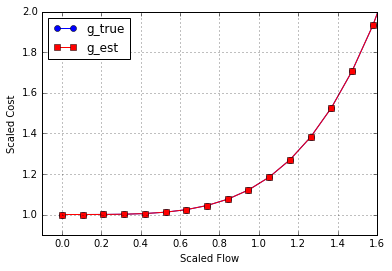

In [17]:
true, = plt.plot(xs, zs_true, "bo-")
est, = plt.plot(xs, zs_est, "rs-")

plt.legend([true, est], ["g_true", "g_est"], loc=0)
plt.xlabel('Scaled Flow')
plt.ylabel('Scaled Cost')
pylab.xlim(-0.1, 1.6)
pylab.ylim(0.9, 2.0)
grid("on")
savefig('fittedCostFunc.eps')